# What gets measured gets managed
### Evaluating labelling and detection tasks performance using the intersection over union metric

In [1]:
import json
import numpy as np
import pandas as pd
from statistics import mean, median
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import stat

In [2]:
def openjson(json_to_load):
    """Open the json file. 
    Arguments: json file to load. """
    f = open(json_to_load)
    jsonfile = json.load(f)
    f.close
    return jsonfile

In [3]:
def get_label_names(json_file):
    jsonfile = openjson(json_file)
    for groups in jsonfile['labelGroups']:
        existing_labels = groups['labels']
        for label in existing_labels:
            print("The label named:'",label['name'],"' has the following id:",label['id'])
        print("Please choose similar labels to use for the calculation of the intersection over union score.")

In [4]:
def get_label_ids(json_file,label_name):
    chosenlabel=[]
    jsonfile = openjson(json_file)
    for groups in jsonfile['labelGroups']:
        existing_labels = groups['labels']
        for label in existing_labels:
            if label['name'] == label_name:
                chosenlabel.append(label['id'])

In [5]:
def get_coordinates(jsonfile, chosenlabel):
    """Extract the SOPInstanceUID, label ID and coordinates for the bounding box from a json file downloaded from https://md.ai/
    Arguments: json file to extract the needed information."""
    coordinate_list=[]
    study_id_list=[]
    label_id_list=[]
    x1_pos_list=[]
    y1_pos_list=[]
    x2_pos_list=[]
    y2_pos_list=[]
    globaldatasetdata = jsonfile['datasets']
    for datasetdata in globaldatasetdata:
        list_of_annotations = datasetdata['annotations']
        for dict_of_annotations in list_of_annotations:
            for label_to_compare in chosenlabel:
                if dict_of_annotations['labelId'] == label_to_compare:
                    study_id = dict_of_annotations['SOPInstanceUID']
                    study_id_list.append(study_id)
                    label_id = dict_of_annotations['labelId']
                    label_id_list.append(label_id)
                    x1_pos = dict_of_annotations['data']['x']
                    x1_pos_list.append(x1_pos)
                    y1_pos = dict_of_annotations['data']['y']
                    y1_pos_list.append(y1_pos)
                    x2_pos = (dict_of_annotations['data']['x']+dict_of_annotations['data']['width'])
                    x2_pos_list.append(x2_pos)
                    y2_pos = (dict_of_annotations['data']['y']+dict_of_annotations['data']['height'])
                    y2_pos_list.append(y2_pos)
                else:
                    pass
        coordinate_list.append(study_id_list)
        coordinate_list.append(label_id_list)
        coordinate_list.append(x1_pos_list)
        coordinate_list.append(y1_pos_list)
        coordinate_list.append(x2_pos_list)
        coordinate_list.append(y2_pos_list)
        return coordinate_list

In [6]:
def create_dataframe(json_1, json_2, chosenlabel):
    """Create pandas dataframes to concatenate both files and join on the SOPInstanceUID"""
    first_coords = get_coordinates(json_1, chosenlabel)
    df_resident = pd.DataFrame(first_coords)
    df_resident = df_resident.transpose()#Transpose each instance into a row
    df_resident.columns = ['id','label','x1','x2', 'y1', 'y2']

    second_coords = get_coordinates(json_2, chosenlabel)
    df_answer = pd.DataFrame(second_coords)
    df_answer = df_answer.transpose()#Transpose each instance into a row
    df_answer.columns = ['id','label','x3','x4', 'y3', 'y4']

    df_final = df_resident.merge(df_answer, how='inner', on='id')
    df_final.drop('label_y', axis=1, inplace=True) #remove the duplicated label information
    return df_final

In [7]:
def bb_intersection_over_union(boxA, boxB): #Reference: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
	""" We assume that the box follows the format:
		box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
		where (x1,y1) and (x3,y3) represent the top left coordinate,
		and (x2,y2) and (x4,y4) represent the bottom right coordinate """
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [8]:
def listofIoU(json_1, json_2, chosenlabel):
    """Create a list of the iou values for each instance evaluated."""
    df_final = create_dataframe(json_1, json_2, chosenlabel)
    dict_of_iou = {}
    for row in df_final.itertuples():
        studyid = row.id
        x1 = row.x1
        x2 = row.x2
        x3 = row.x3
        x4 = row.x4
        y1 = row.y1
        y2 = row.y2
        y3 = row.y3
        y4 = row.y4
        box1 = [x1,y1,x2,y2]
        box2 = [x3,y3,x4,y4]
        iou = bb_intersection_over_union(box1,box2)
        dict_of_iou[studyid] = iou
        
    return dict_of_iou

In [9]:
def get_measures(list_of_iou):
    """Print the accuracy metrics."""

    print(f'The resident has the following accuracy metrics (based on Intersection over Union):')
    print(f'Mean:{mean(list_of_iou)}\nMedian: {median(list_of_iou)}')
    print(f'Min:{min(list_of_iou)}\nMax:{max(list_of_iou)}')


In [10]:
def evaluation_bounding_box(json_1, json_2, chosenlabel):
    """Main script to run.
    Arguments: json files to load (2 files to compare)."""
    json_answer_1 = openjson(json_1)
    json_answer_2 = openjson(json_2)
    list_of_iou = listofIoU(json_answer_1, json_answer_2, chosenlabel)
    #get_measures(list_of_iou)
    return list_of_iou

In [11]:
def get_chosenlabel_list(filename_list):
    chosenlabel=[]
    for filename in filename_list:
        if filename is not None:
            jsonfile = openjson(filename)
            for groups in jsonfile['labelGroups']:
                existing_labels = groups['labels']
                for label in existing_labels:
                    if label['name'] == label_name:
                        chosenlabel.append(label['id'])
        else:
            pass
    return chosenlabel

In [12]:
def iou_of_residents(filename_list, chosenlabel):
    output = pd.DataFrame(columns = ['id'])
    resident_number = 1
    for i in filename_list:
        if i == json_1:
            pass
        elif i is None:
            pass
        else:
            dict_of_acuracies = evaluation_bounding_box(filename_list[0],i,chosenlabel)
            df_dictionary = pd.DataFrame([dict_of_acuracies])
            df_dictionary = pd.DataFrame([dict_of_acuracies])
            df_dictionary = df_dictionary.transpose()            
            df_dictionary = df_dictionary.reset_index()
            df_dictionary.columns = ['id',f'resident_{resident_number}_score']
            output = output.merge(df_dictionary, how='outer', on='id')
            resident_number +=1
    return output

## Manual data entry needed:
Add the necessary data in order to run the script and obtain the residents scores.

In [13]:
#Preparing to run the script
#File for ground truth:
json_1 = "specialist.json"
#File for residents to be evaluated:
json_2 = "resident1.json"
json_3 = "resident2.json"
json_4 = "resident3.json"
json_5 = None
json_6 = None
#Name of the label to evaluate - If unsure of all the labels existing use get_label_names(filename)
label_name = "Mass"


In [14]:
filename_list=[json_1,json_2,json_3,json_4,json_5,json_6] #The list of filenames to evaluate
chosenlabel = get_chosenlabel_list(filename_list) #The list of labels to be evaluated
df = iou_of_residents(filename_list, chosenlabel) #A pandas dataframe to gather the intersection over union scores
df.head()

,id,resident_1_score,resident_2_score,resident_3_score
0,1.3.6.1.4.1.9590.100.1.2.110937021913447778701...,0.918871,0.926531,0.985570
1,1.3.6.1.4.1.9590.100.1.2.119685568312982243230...,0.000000,0.000000,NaN
2,1.3.6.1.4.1.9590.100.1.2.128450943011232588835...,0.975047,0.926623,NaN
3,1.3.6.1.4.1.9590.100.1.2.195411583812846996830...,0.000000,0.000000,0.000000
4,1.3.6.1.4.1.9590.100.1.2.218230735110408535824...,0.929363,0.881743,0.926842


In [15]:
resident1_dropped_na = df['resident_1_score'].dropna()
resident2_dropped_na = df['resident_2_score'].dropna()
resident3_dropped_na = df['resident_3_score'].dropna()
df_filled = df.fillna(0)
resident1 = df_filled['resident_1_score']
resident2 = df_filled['resident_2_score']
resident3 = df_filled['resident_3_score']

Now that we extracted the scores from each resident, we can perform a adequate analysis.

In [16]:
print(f"Total number of cases: {(df.shape)[0]-1}")
print('\nNumber of cases where the resident did not labeled any lesion:')
resident_number_cases = 1
for i in filename_list:
        if i == json_1:
            pass
        elif i is None:
            pass
        else:
            print(f"Resident {resident_number_cases} : {df.isnull().sum(axis = 0)[resident_number_cases]} cases")

            resident_number_cases +=1

Total number of cases: 50

Number of cases where the resident did not labeled any lesion:
Resident 1 : 5 cases
Resident 2 : 8 cases
Resident 3 : 12 cases


In [17]:
print("Mean score in annotated cases:")
print(f"Resident 1 score: {resident1_dropped_na.mean()}.")
print(f"Resident 2 score: {resident2_dropped_na.mean()}.")
print(f"Resident 3 score: {resident3_dropped_na.mean()}.")

print("\nMean score in the total number of cases:")
print(f"Resident 1 score: {resident1.mean()}.")
print(f"Resident 2 score: {resident2.mean()}.")
print(f"Resident 3 score: {resident3.mean()}.")

Mean score in annotated cases:
Resident 1 score: 0.6148095723922848.
Resident 2 score: 0.5168271316819512.
Resident 3 score: 0.6642201247909879.

Mean score in the total number of cases:
Resident 1 score: 0.5545341241185314.
Resident 2 score: 0.43575620906517454.
Resident 3 score: 0.5079330366048731.


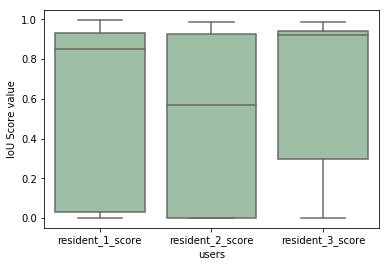

In [18]:
df_melt = pd.melt(df.reset_index(), value_vars=['resident_1_score', 'resident_2_score', 'resident_3_score'])
# replace column names
df_melt.columns = [ 'users', 'IoU Score value']

ax = sns.boxplot(x='users', y='IoU Score value', data=df_melt, color='#99c2a2')
plt.show()

### Statistical analysis:
#### One-way ANOVA 

In [19]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value

print("One-way ANOVA in annotated cases:")

fvalue, pvalue = stats.f_oneway(resident1_dropped_na, resident2_dropped_na, resident3_dropped_na)
print(f"ANOVA f-value: {fvalue}\nANOVA p-value: {pvalue}")

if pvalue > 0.05:
    print("No statistical difference was found between the means of the groups.")
else:
    print("A statistical difference was found between the means of the groups.")


print("\nOne-way ANOVA in the total number of cases:")
fvalue, pvalue = stats.f_oneway(resident1, resident2, resident3)
print(f"ANOVA f-value: {fvalue}\nANOVA p-value: {pvalue}")

if pvalue > 0.05:
    print("No statistical difference was found between the means of the groups.")
else:
    print("A statistical difference was found between the means of the groups.")


One-way ANOVA in annotated cases:
ANOVA f-value: 1.4060644963739442
ANOVA p-value: 0.24895536975262178
No statistical difference was found between the means of the groups.

One-way ANOVA in the total number of cases:
ANOVA f-value: 0.9673988809571303
ANOVA p-value: 0.3824287387440096
No statistical difference was found between the means of the groups.
